In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [2]:
model= keras.saving.load_model('../../Models/CNN_6_1_1.keras')

c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
# GCGGGAAGACAACTAGGGG is the last 19 bp, 20 bp is ITR, first bp of ITR is depends on the promoter (it is before the sticky end)
# 20bp up sequence

X =[
   'AATACTAGAGGTCTTCCGACTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGGCGGGAAGACAACTAGGGG',
   'AATACTAGAGGTCTTCCGACTTGACACTATTTCCTATTTCTCTTATAATTTGTGTTGCGGGAAGACAACTAGGGG',
   'AATACTAGAGGTCTTCCGACAAGACGCTATTTCCTATTTCTCTTATAATTTGTGTTGCGGGAAGACAACTAGGGG',
   'AATACTAGAGGTCTTCCGACCCCCTATTTCCTATTTCTGTAGTCATAGGGTGTTGCGGGAAGACAACTAGGGG',
   'AATACTAGAGGTCTTCCGACTTGACAATTAATCATCCGGCTCGTAATTTATGTGGAGCGGGAAGACAACTAGGGG',
   'AATACTAGAGGTCTTCCGACTTAACAATTAATCATCCGGCTCGTAATTTATGTGGAGCGGGAAGACAACTAGGGG',
   'ATACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATCTATATTTAACAAAGCGGGAAGACAACTAGGGG',
   'TACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATATATATTTAACAAAGCGGGAAGACAACTAGGGG',
]

In [ ]:
def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = []
    for nucleotide in sequence:
         encoding += [mapping[nucleotide]]
    return encoding

upstream_padding = []
max_length = model.input_shape[1]
for seq in X:
    zeros = '0' * (max_length-len(seq))
    upstream_padding += [padded_one_hot_encode(zeros + seq)]

X = np.array(upstream_padding)

In [7]:
promoters = ['pLac', 'Low', 'Medium', 'High', 'P5', 'P533A', 'OsmY', 'OsmY_C13A']
scaled_predictions = model.predict(X).flatten()
prediction_df = pd.DataFrame({'Promoter': promoters, 'Prediction': scaled_predictions})
prediction_df.head(None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


,Promoter,Prediction
0,pLac,0.563776
1,Low,0.497780
2,Medium,0.590328
3,High,0.681404
4,P5,0.539236
5,P533A,0.575222
6,OsmY,0.637376
7,OsmY_C13A,0.682900


## Getting observed RFP

In [8]:
RFP_df = pd.read_csv('../../Data/RFP/2024_07_03_Fluorescence_Data_formatted.csv')
RFP_df.head()

,Media,Promoter,Rep,ABS590,Ex550Em6630,Relative Fluorescence
0,LB,Blank,Rep1,-0.002298,3000.0,-1.305247e+06
1,LB,Blank,Rep2,0.002298,-3000.0,-1.305247e+06
2,LB,pLac,Rep1,0.890547,127596.0,1.432782e+05
3,LB,pLac,Rep2,0.898603,127909.0,1.423420e+05
4,LB,Low,Rep1,0.936451,1755972.0,1.875135e+06


In [9]:
RFP_df = RFP_df[RFP_df['Promoter'] != 'Blank'].reset_index(drop=True)
RFP_df.head()

,Media,Promoter,Rep,ABS590,Ex550Em6630,Relative Fluorescence
0,LB,pLac,Rep1,0.890547,127596.0,1.432782e+05
1,LB,pLac,Rep2,0.898603,127909.0,1.423420e+05
2,LB,Low,Rep1,0.936451,1755972.0,1.875135e+06
3,LB,Low,Rep2,0.888620,1743759.0,1.962321e+06
4,LB,Medium,Rep1,0.741436,190548.0,2.569984e+05


In [10]:
comparison_df = RFP_df
comparison_df = comparison_df.merge(prediction_df[['Promoter', 'Prediction']], on='Promoter', how='left')
comparison_df.head()

,Media,Promoter,Rep,ABS590,Ex550Em6630,Relative Fluorescence,Prediction
0,LB,pLac,Rep1,0.890547,127596.0,1.432782e+05,0.563776
1,LB,pLac,Rep2,0.898603,127909.0,1.423420e+05,0.563776
2,LB,Low,Rep1,0.936451,1755972.0,1.875135e+06,0.497780
3,LB,Low,Rep2,0.888620,1743759.0,1.962321e+06,0.497780
4,LB,Medium,Rep1,0.741436,190548.0,2.569984e+05,0.590328


In [11]:
# Drop rows with NaN values
comparison_df.dropna(inplace=True)
comparison_df.head()

,Media,Promoter,Rep,ABS590,Ex550Em6630,Relative Fluorescence,Prediction
0,LB,pLac,Rep1,0.890547,127596.0,1.432782e+05,0.563776
1,LB,pLac,Rep2,0.898603,127909.0,1.423420e+05,0.563776
2,LB,Low,Rep1,0.936451,1755972.0,1.875135e+06,0.497780
3,LB,Low,Rep2,0.888620,1743759.0,1.962321e+06,0.497780
4,LB,Medium,Rep1,0.741436,190548.0,2.569984e+05,0.590328


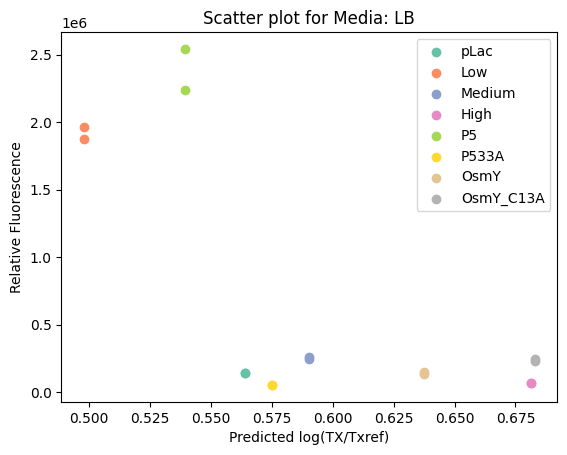

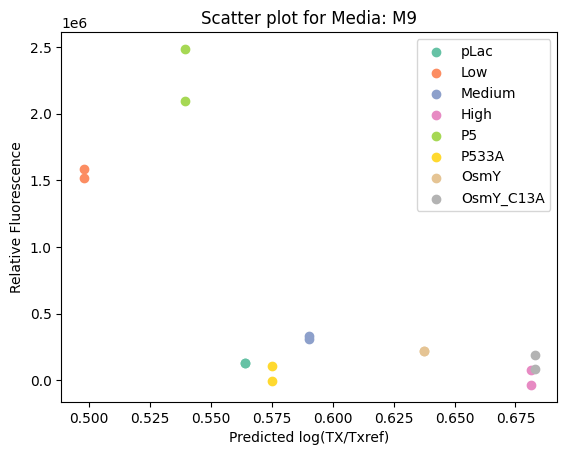

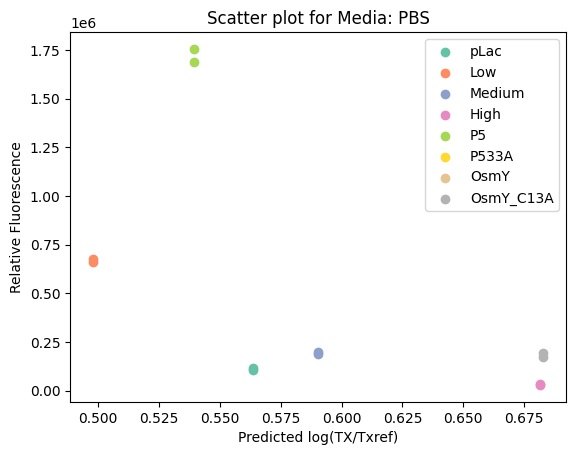

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


unique_media = comparison_df['Media'].unique()
unique_promoters = comparison_df['Promoter'].unique()

colors = plt.cm.Set2(np.linspace(0, 1, len(unique_promoters)))
color_map = {promoter: colors[i] for i, promoter in enumerate(unique_promoters)}

for media in unique_media:
    subset_df_media = comparison_df[comparison_df['Media'] == media]

    plt.figure()

    for i, promoter in enumerate(unique_promoters):
        promoter_subset_df = subset_df_media[subset_df_media['Promoter'] == promoter]
        color = color_map[promoter]
        plt.scatter(promoter_subset_df['Prediction'], promoter_subset_df['Relative Fluorescence'], c=[color], label=promoter)

        ##print(promoter_subset_df['Relative Fluorescence'])

    plt.xlabel('Predicted log(TX/Txref)')
    plt.ylabel('Relative Fluorescence')
    plt.title(f'Scatter plot for Media: {media}')
    plt.legend()

plt.show()


## Log transform relative fluorescence

In [13]:
import numpy as np

comparison_df['Log Relative Fluorescence'] = comparison_df.apply(lambda row: np.log(row['Relative Fluorescence']), axis=1)

comparison_df.head()

C:\Users\rsore\AppData\Local\Temp\ipykernel_23256\1367179745.py:3: RuntimeWarning: invalid value encountered in log
  comparison_df['Log Relative Fluorescence'] = comparison_df.apply(lambda row: np.log(row['Relative Fluorescence']), axis=1)


,Media,Promoter,Rep,ABS590,Ex550Em6630,Relative Fluorescence,Prediction,Log Relative Fluorescence
0,LB,pLac,Rep1,0.890547,127596.0,1.432782e+05,0.563776,11.872543
1,LB,pLac,Rep2,0.898603,127909.0,1.423420e+05,0.563776,11.865988
2,LB,Low,Rep1,0.936451,1755972.0,1.875135e+06,0.497780,14.444191
3,LB,Low,Rep2,0.888620,1743759.0,1.962321e+06,0.497780,14.489639
4,LB,Medium,Rep1,0.741436,190548.0,2.569984e+05,0.590328,12.456825


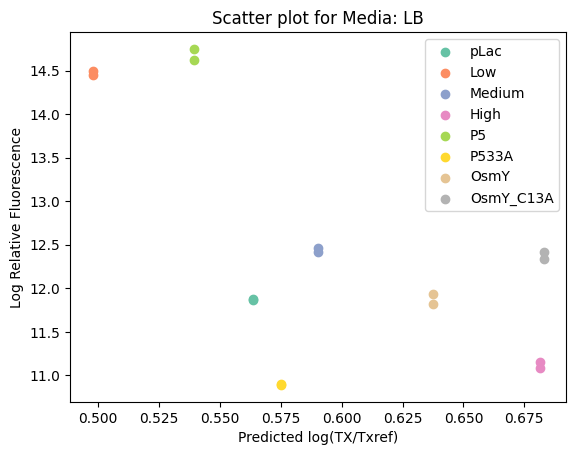

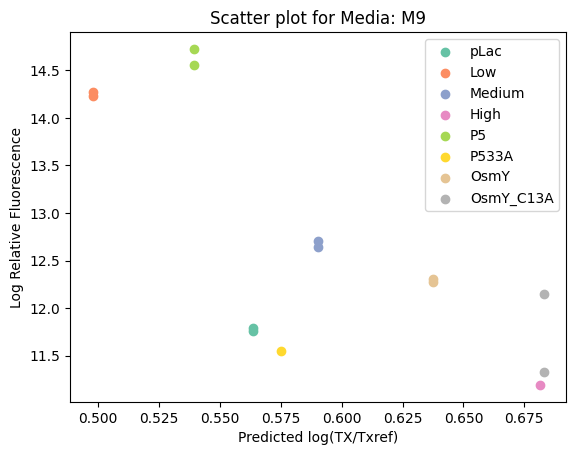

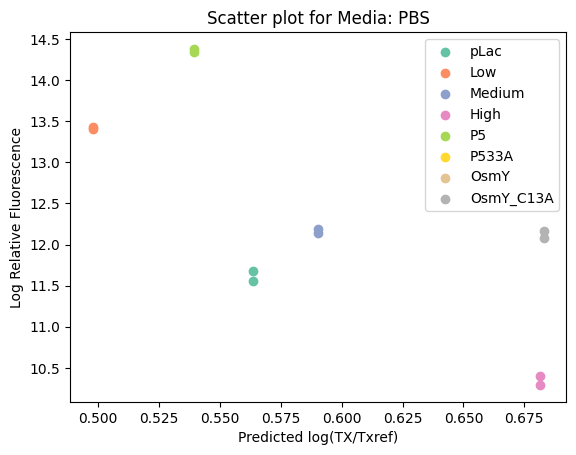

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


unique_media = comparison_df['Media'].unique()
unique_promoters = comparison_df['Promoter'].unique()

colors = plt.cm.Set2(np.linspace(0, 1, len(unique_promoters)))
color_map = {promoter: colors[i] for i, promoter in enumerate(unique_promoters)}

for media in unique_media:
    subset_df_media = comparison_df[comparison_df['Media'] == media]

    plt.figure()

    for i, promoter in enumerate(unique_promoters):
        promoter_subset_df = subset_df_media[subset_df_media['Promoter'] == promoter]
        color = color_map[promoter]
        plt.scatter(promoter_subset_df['Prediction'], promoter_subset_df['Log Relative Fluorescence'], c=[color], label=promoter)

    plt.xlabel('Predicted log(TX/Txref)')
    plt.ylabel('Log Relative Fluorescence')
    plt.title(f'Scatter plot for Media: {media}')
    plt.legend()

plt.show()


## Linear regression to convert

Fit: y=-13.49x + 20.51


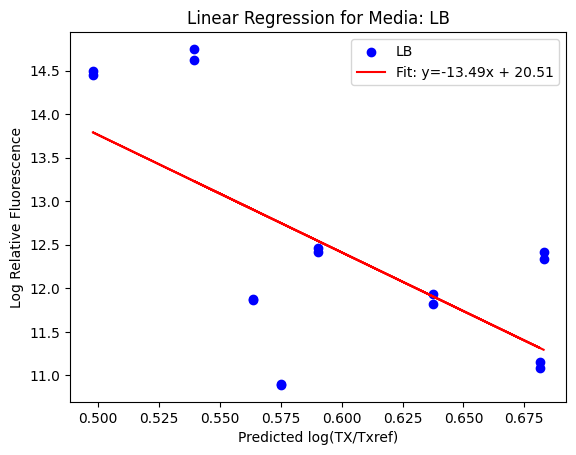

Fit: y=nanx + nan


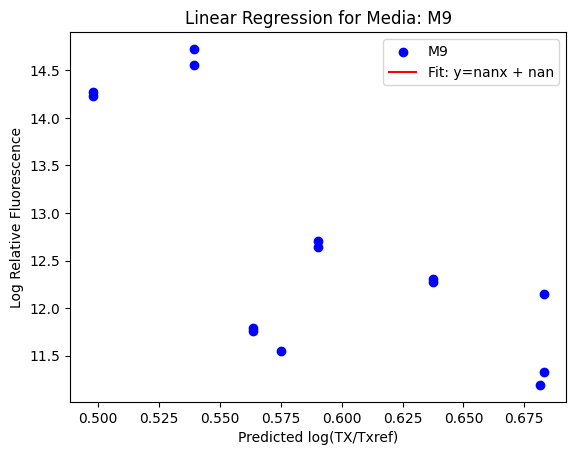

Fit: y=-13.43x + 20.29


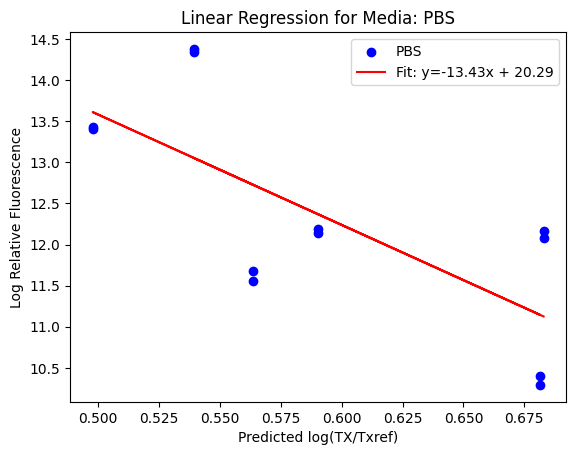

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

unique_media = comparison_df['Media'].unique()

for media in unique_media:
    subset_df_media = comparison_df[comparison_df['Media'] == media]
    
    if len(subset_df_media) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(
            subset_df_media['Prediction'], subset_df_media['Log Relative Fluorescence']
        )
        
        plt.scatter(subset_df_media['Prediction'], subset_df_media['Log Relative Fluorescence'], label=media, color='b')

        x_vals = np.array(subset_df_media['Prediction'])
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, color='r', label=f'Fit: y={slope:.2f}x + {intercept:.2f}')
        print(f'Fit: y={slope:.2f}x + {intercept:.2f}')
        
        plt.xlabel('Predicted log(TX/Txref)')
        plt.ylabel('Log Relative Fluorescence')
        plt.title(f'Linear Regression for Media: {media}')
        plt.legend()

        plt.show()


Fit: y=-14.77x + 21.42


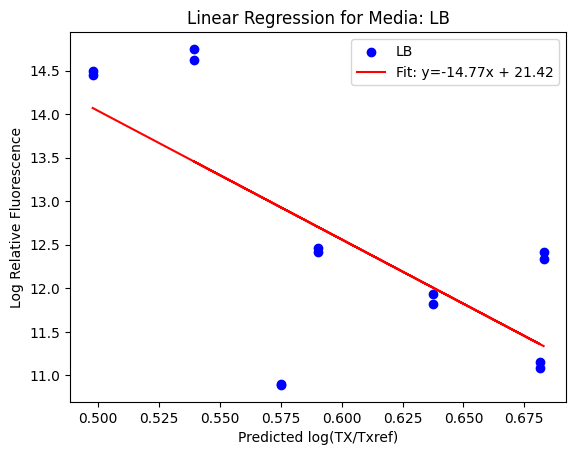

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

target_media = 'LB'
exclude_promoter = 'pLac'
subset_df = comparison_df[(comparison_df['Media'] == target_media) & (comparison_df['Promoter'] != exclude_promoter)]

if len(subset_df) > 1:
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(
        subset_df['Prediction'], subset_df['Log Relative Fluorescence']
    )
    
    # Scatter plot
    plt.scatter(subset_df['Prediction'], subset_df['Log Relative Fluorescence'], label=target_media, color='b')

    # Regression line
    x_vals = np.array(subset_df['Prediction'])
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color='r', label=f'Fit: y={slope:.2f}x + {intercept:.2f}')
    print(f'Fit: y={slope:.2f}x + {intercept:.2f}')
    
    # Plot formatting
    plt.xlabel('Predicted log(TX/Txref)')
    plt.ylabel('Log Relative Fluorescence')
    plt.title(f'Linear Regression for Media: {target_media}')
    plt.legend()
    plt.show()


In [17]:
def convert_prediction_to_fluorescence(prediction, slope, intercept):
    """
    Convert a prediction to relative fluorescence.

    Parameters:
    - prediction (float): The predicted value.
    - slope (float): The slope of the linear regression.
    - intercept (float): The intercept of the linear regression.

    Returns:
    - float: The relative fluorescence.
    """
    log_relative_fluorescence = slope * prediction + intercept
    relative_fluorescence = np.exp(log_relative_fluorescence)
    return relative_fluorescence



In [18]:
slope = 12.98
intercept = 7.96
prediction = 0.5

fluorescence = convert_prediction_to_fluorescence(prediction, slope, intercept)
print(f"Relative Fluorescence: {fluorescence}")


Relative Fluorescence: 1886058.9531782998


## Testing conversion with example input

Relative Fluorescence: 13.152000000000001


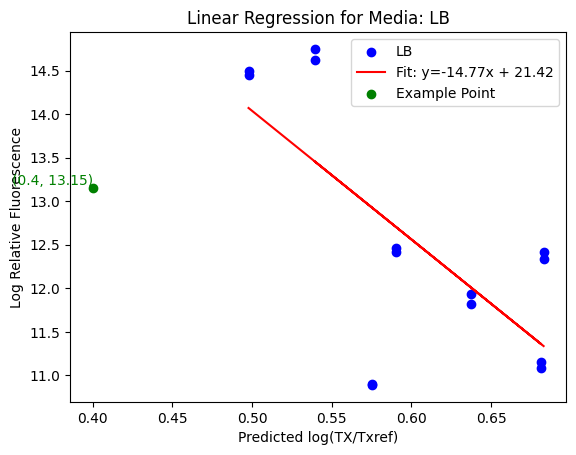

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

target_media = 'LB'
exclude_promoter = 'pLac'

# Example values
example_slope = 12.98
example_intercept = 7.96
example_prediction = 0.4

# Calculate the example fluorescence LOG CONVERTED
example_fluorescence = np.log(convert_prediction_to_fluorescence(example_prediction, example_slope, example_intercept))
print(f"Relative Fluorescence: {example_fluorescence}")

# Filter the DataFrame
subset_df = comparison_df[(comparison_df['Media'] == target_media) & (comparison_df['Promoter'] != exclude_promoter)]

if len(subset_df) > 1:
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(
        subset_df['Prediction'], subset_df['Log Relative Fluorescence']
    )
    
    # Scatter plot
    plt.scatter(subset_df['Prediction'], subset_df['Log Relative Fluorescence'], label=target_media, color='b')

    # Regression line
    x_vals = np.array(subset_df['Prediction'])
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color='r', label=f'Fit: y={slope:.2f}x + {intercept:.2f}')
    
    # Plot the example point
    plt.scatter(example_prediction, example_fluorescence, color='g', zorder=5, label='Example Point')
    plt.text(example_prediction, example_fluorescence, f'({example_prediction}, {example_fluorescence:.2f})', 
             verticalalignment='bottom', horizontalalignment='right', color='g')

    # Plot formatting
    plt.xlabel('Predicted log(TX/Txref)')
    plt.ylabel('Log Relative Fluorescence')
    plt.title(f'Linear Regression for Media: {target_media}')
    plt.legend()
    plt.show()


In [20]:
slope = 12.98
intercept = 7.96
min = 1
max = 0


min_fluorescence = convert_prediction_to_fluorescence(min, slope, intercept)
print(f"Relative Fluorescence: {min_fluorescence}")

max_fluorescence = convert_prediction_to_fluorescence(max, slope, intercept)
print(f"Max Relative Fluorescence: {max_fluorescence}")

Relative Fluorescence: 1242013885.0691547
Max Relative Fluorescence: 2864.0729525064603


In [21]:
comparison_df['Predicted Fluorescence'] = comparison_df.apply(lambda row: convert_prediction_to_fluorescence(row['Prediction'], slope, intercept), axis=1)
print(comparison_df.head())

  Media Promoter   Rep    ABS590  Ex550Em6630  Relative Fluorescence  \
0    LB     pLac  Rep1  0.890547     127596.0           1.432782e+05   
1    LB     pLac  Rep2  0.898603     127909.0           1.423420e+05   
2    LB      Low  Rep1  0.936451    1755972.0           1.875135e+06   
3    LB      Low  Rep2  0.888620    1743759.0           1.962321e+06   
4    LB   Medium  Rep1  0.741436     190548.0           2.569984e+05   

   Prediction  Log Relative Fluorescence  Predicted Fluorescence  
0    0.563776                  11.872543            4.315874e+06  
1    0.563776                  11.865988            4.315874e+06  
2    0.497780                  14.444191            1.832487e+06  
3    0.497780                  14.489639            1.832487e+06  
4    0.590328                  12.456825            6.091856e+06  


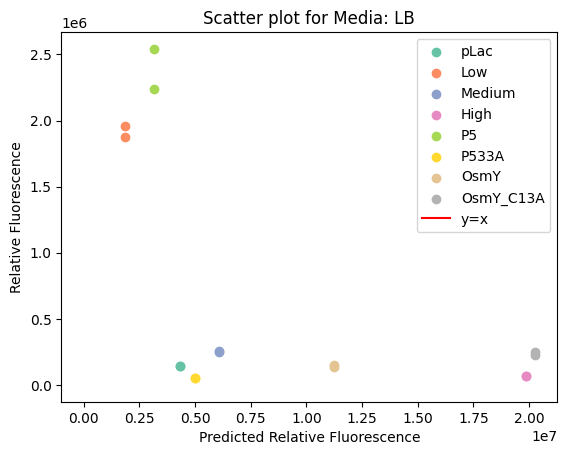

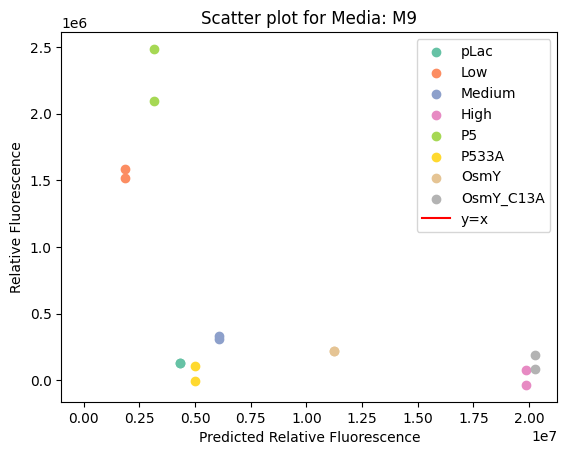

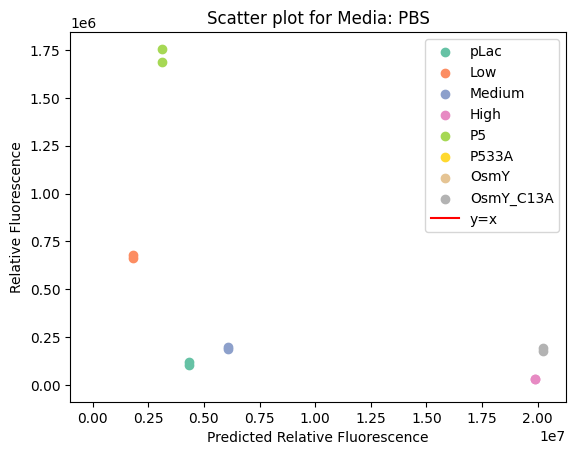

In [22]:
unique_media = comparison_df['Media'].unique()
unique_promoters = comparison_df['Promoter'].unique()

colors = plt.cm.Set2(np.linspace(0, 1, len(unique_promoters)))
color_map = {promoter: colors[i] for i, promoter in enumerate(unique_promoters)}

x_val= np.linspace(0,10,100)
y_val= x_val.copy()

for media in unique_media:
    subset_df_media = comparison_df[comparison_df['Media'] == media]

    plt.figure()

    for i, promoter in enumerate(unique_promoters):
        promoter_subset_df = subset_df_media[subset_df_media['Promoter'] == promoter]
        color = color_map[promoter]
        plt.scatter(promoter_subset_df['Predicted Fluorescence'], promoter_subset_df['Relative Fluorescence'], c=[color], label=promoter)

    plt.xlabel('Predicted Relative Fluorescence')
    plt.ylabel('Relative Fluorescence')
    plt.plot(x_val, y_val, color='r', label='y=x')

    plt.title(f'Scatter plot for Media: {media}')
    plt.legend()

plt.show()